In [1]:
%matplotlib inline


# Multi instrument joint 3D and 1D analysis

Joint 3D analysis using 3D Fermi datasets, a H.E.S.S. reduced spectrum and HAWC and LHAASO flux points. This noteboook is adapted from https://docs.gammapy.org/1.0.1/tutorials/analysis-3d/analysis_mwl.html with some minor changes.


## Context

Some science studies require to combine heterogeneous data from various
instruments to extract physical information. In particular, it is often
useful to add flux measurements of a source at different energies to an
analysis to better constrain the wide-band spectral parameters. This can
be done using a joint fit of heterogeneous datasets.

**Objectives: Constrain the spectral parameters of the gamma-ray
emission from the Crab nebula between 10 GeV and 1 PeV, using a 3D
Fermi dataset, a H.E.S.S. reduced spectrum and HAWC and LHAASO flux points.**

## Proposed approach

This tutorial illustrates how to perform a joint modeling and fitting of
the Crab Nebula spectrum using different datasets. The spectral
parameters are optimized by combining a 3D analysis of Fermi-LAT data, a
ON/OFF spectral analysis of HESS data, and flux points from HAWC and LHAASO.

In this tutorial we are going to use pre-made datasets. We prepared maps
of the Crab region as seen by Fermi-LAT using the same event selection
than the [3FHL catalog](https://arxiv.org/abs/1702.00664)_ (7 years of
data with energy from 10 GeV to 2 TeV). For the HESS ON/OFF analysis we
used two observations from the [first public data
release](https://arxiv.org/abs/1810.04516)_ with a significant signal
from energy of about 600 GeV to 10 TeV. These observations have an
offset of 0.5° and a zenith angle of 45-48°. The HAWC flux points data
are taken from a [recent
analysis](https://arxiv.org/pdf/1905.12518.pdf)_ based on 2.5 years of
data with energy between 300 Gev and 300 TeV. For the very high energy part we use recent [data](https://arxiv.org/pdf/2111.06545.pdf) from LHAASO extending over 1 PeV.

## The setup


In [14]:
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.constants import c
import matplotlib.pyplot as plt
from gammapy.datasets import Datasets#, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (Models, 
                                     SkyModel, 
                                     create_crab_spectral_model,
                                     NaimaSpectralModel, 
#                                      PowerLawSpectralModel,
#                                      ExpCutoffPowerLawSpectralModel,
#                                      LogParabolaSpectralModel,
                                     SmoothBrokenPowerLawSpectralModel,
                                     PointSpatialModel,
                                     GaussianSpatialModel,
                                     DiskSpatialModel)

from naima.models import (
    ExponentialCutoffBrokenPowerLaw,
    InverseCompton,
    Synchrotron,
)

## Datasets

The `datasets` object contains each dataset previously written to disk datasets.yaml, models.yaml, and several data files
specific to each dataset. The `datasets` can be read from these files.




In [8]:
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)

filename = path / "crab_10GeV_100TeV_datasets.yaml"

datasets = Datasets.read(filename)

print(datasets)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : ['Fermi-LAT-bkg']

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : FluxPointsDataset
  Name       : LHAASO
  Instrument : 
  Models     : 




The total cost function minimized by the fit is $$\mathcal{C} = -2\ln(\mathcal{L_\mathrm{Fermi}}) - 2\ln(\mathcal{L_\mathrm{HESS}}) + \chi^2_\mathrm{HAWC} + + \chi^2_\mathrm{LHAASO}.$$

- For the 3D Fermi dataset where the mean of the background is supposed to be known the so-called *cash* statistics is used where $$-2\ln(\mathcal{L_\mathrm{Fermi}}) = 2(\mu_\mathrm{on}-n_\mathrm{on}\ln\mu_\mathrm{on})$$ with $\mu_\mathrm{on} = \mu_\mathrm{sig}+\mu_\mathrm{bkg}$ the predicted number of counts by the models and $n_\mathrm{on}$ the measured number. The statistics is calculated per pixel and summed in the end.



- For the 1D HESS dataset where the background is measured from the Off-regions we use the *WStat* $$-2\ln(\mathcal{L_\mathrm{HESS}}) = 2(\mu_\mathrm{sig}+(1+1/\alpha)\mu_\mathrm{bkg} - n_\mathrm{on}\ln(\mu_\mathrm{sig} + \mu_\mathrm{bkg}) - n_\mathrm{off}\ln(\mu_\mathrm{bkg}/\alpha)),$$ where in the most general case, where $\mu_\mathrm{sig}$ and $\mu_\mathrm{bkg}$ are free, the minimum is at $$\mu_\mathrm{sig} = n_\mathrm{on} - \alpha n_\mathrm{off}$$ $$\mu_\mathrm{bkg}=\alpha n_\mathrm{off}$$



- For the `FluxPointsDatasets` the usual $\chi^2$ statistics is used.

Why are we allowed to add all those different statistics in the combined likelihood?

## Define the models

In order to decribe the Crab's emission we need to define a `SkyModel` with a spectral component for the 1D datasets and an additional spatial component for the Fermi 3D dataset. 

Choose appropriate models and run the fit.

In [42]:
### Start with the spectral models ###

# Stuff for the Naima Spectral Model
# ----------------------------------
ECBPL = ExponentialCutoffBrokenPowerLaw(
    amplitude=5.5e+35 / u.eV,
    e_0=1 * u.TeV,
    e_break=2.5 * u.TeV,
    alpha_1=2.2e+00,
    alpha_2=3.7,
    e_cutoff=3.497e+01 * u.PeV,
    beta=2.017e+00,
)

SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV
Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

IC = InverseCompton(
    ECBPL,
    seed_photon_fields=[
        "CMB",
        ["SSC", Esy, phn_sy],
       ["FIR", 2.5 * u.K, 0.15 * u.eV / u.cm ** 3],
    ],
    Eemax=50 * u.PeV,
    Eemin=0.1 * u.GeV,
)
# ----------------------------------

spectral_model_naima = NaimaSpectralModel(radiative_model=IC, distance=2 * u.kpc, nested_models={'SSC':{'B':SYN.B, 'radius':Rpwn}})
spectral_model_LP = create_crab_spectral_model('magic_lp')
spectral_model_PL = create_crab_spectral_model('hess_pl')
spectral_model_ECPL = create_crab_spectral_model('hess_ecpl')
spectral_model_SBPL = SmoothBrokenPowerLawSpectralModel(amplitude='1.5879e-10 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          index1=1.74, 
                                          index2=2.84,
                                          ebreak=0.39*u.TeV,
                                          beta=1) 

### Now the spatial models ###
spatial_model_point = PointSpatialModel(lon_0="184.55 deg", lat_0="-5.78 deg", frame = 'galactic')
spatial_model_gauss = spatial_model=GaussianSpatialModel(lon_0="184.55 deg", lat_0="-5.78 deg", sigma='1.9e-02 deg', frame = 'galactic')
spatial_model_gauss = spatial_model=GaussianSpatialModel(lon_0="184.55 deg", lat_0="-5.78 deg", r0='2.3e-02 deg', frame = 'galactic')

### Define the 3D SkyModel ###
#** Change to the best suited models here **#
#   (The Naima model takes long for fitting)
crab_model = SkyModel(
    spatial_model=spatial_model_point,
    spectral_model=spectral_model_naima,
    name='Crab')

# freeze all spatial parameters
crab_model.spatial_model.parameters.freeze_all()

### Add the models to the datasets
models = Models.read(path / "Fermi-LAT-3FHL_models.yaml") # the bkg model for Fermi
models.append(crab_model)
datasets.models = models

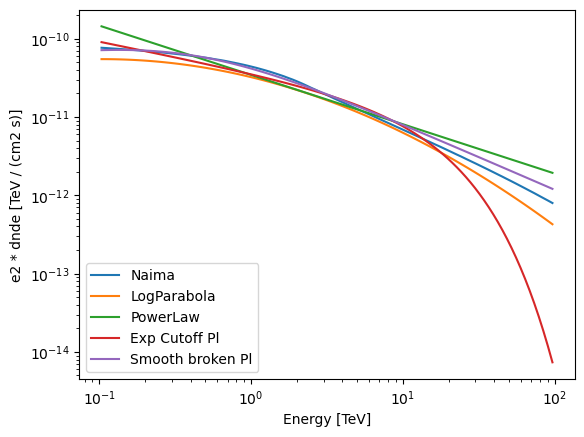

In [27]:
kwargs={'energy_bounds':[0.1,100]*u.TeV, 'energy_power':2}
spectral_model_naima.plot(label='Naima', **kwargs)
spectral_model_LP.plot(label='LogParabola', **kwargs)
spectral_model_PL.plot(label='PowerLaw', **kwargs)
spectral_model_ECPL.plot(label='Exp Cutoff Pl', **kwargs)
spectral_model_SBPL.plot(label='Smooth broken Pl', **kwargs)

plt.legend()

In [5]:
test=datasets['LHAASO']

<AxesSubplot: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

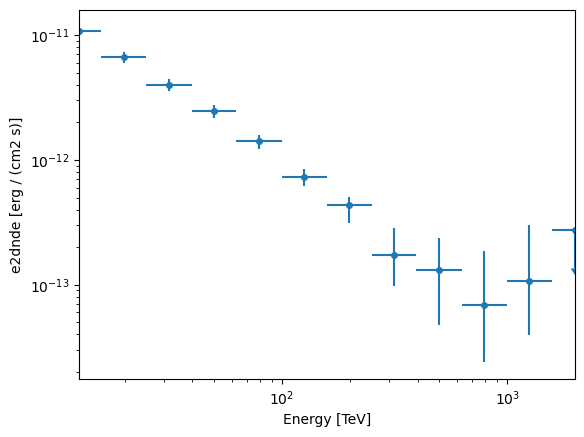

In [7]:
test.data.plot()

## Joint analysis

We run the fit on the `Datasets` object that include a dataset for
each instrument




In [ ]:
fit_joint = Fit()
results_joint = fit_joint.run(datasets=datasets)
print(results_joint)

Let’s display only the parameters of the Crab spectral model




In [38]:
crab_spec = datasets[0].models["Crab"].spectral_model
print(crab_spec)

SmoothBrokenPowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral    index1 2.1985e+00                ... nan  False   False     
spectral    index2 3.2183e+00                ... nan  False   False     
spectral amplitude 4.1986e-11 cm-2 s-1 TeV-1 ... nan  False    True     
spectral    ebreak 4.8454e+00            TeV ... nan  False   False     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral      beta 1.0000e+00                ... nan   True   False     


We can compute flux points for Fermi-LAT and HESS datasets in order plot
them together with the HAWC flux point.




In [40]:
# compute Fermi-LAT and HESS flux points
energy_edges = MapAxis.from_energy_bounds("10 GeV", "2 TeV", nbin=5).edges

flux_points_fermi = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="Crab",
).run([datasets["Fermi-LAT"]])


energy_edges = MapAxis.from_bounds(1, 15, nbin=6, interp="log", unit="TeV").edges

flux_points_hess = FluxPointsEstimator(
    energy_edges=energy_edges, source="Crab", selection_optional=["ul"]
).run([datasets["HESS"]])

# set HAWC and LHAASO flux points
flux_points_hawc = datasets['HAWC'].data
flux_points_LHAASO = datasets['LHAASO'].data

Now, Let’s plot the Crab spectrum fitted and the flux points of each
instrument.




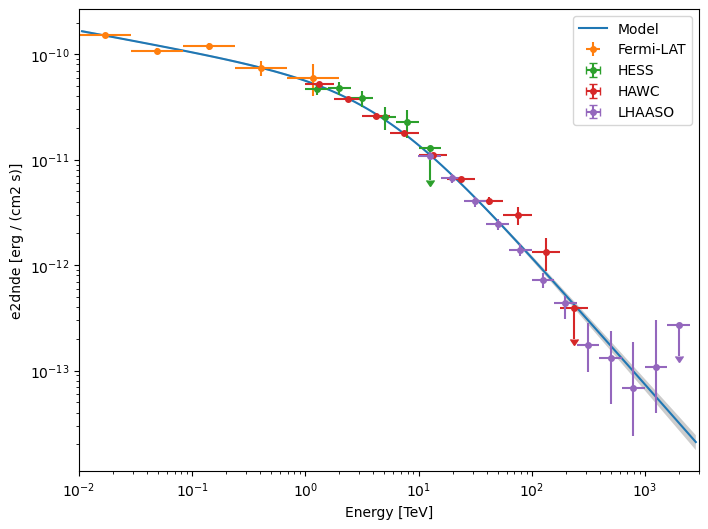

In [41]:
# display spectrum and flux points
fig, ax = plt.subplots(figsize=(8, 6))

energy_bounds = [0.01, 3e3] * u.TeV
sed_type = "e2dnde"

crab_spec.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
crab_spec.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)

flux_points_fermi.plot(ax=ax, sed_type=sed_type, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, sed_type=sed_type, label="HESS")
flux_points_hawc.plot(ax=ax, sed_type=sed_type, label="HAWC")
flux_points_LHAASO.plot(ax=ax, sed_type=sed_type, label="LHAASO")

ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [76]:
print(datasets['LHAASO'])

FluxPointsDataset
-----------------

  Name                            : LHAASO 

  Number of total flux points     : 12 
  Number of fit bins              : 11 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 21.44

  Number of models                : 1 
  Number of parameters            : 6
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : Crab Nebula
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      amplitude                     :   2.04e-03   +/- 1.5e-04 1 / (cm2 s TeV)
      reference             (frozen):      0.000       TeV         
      alpha                         :      1.095   +/-    0.02             
      beta                          :      0.071   +/-    0.00             
      lon_0                 (frozen):     83.633       deg         
      